In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import obonet
import networkx as nx
from collections import Counter
from scipy import stats

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Paths
DATA_DIR = '/home/myvh/hoang/CAFA-6-Protein-Function-Prediction-Kaggle/data'
TRAIN_DIR = f'{DATA_DIR}/Train'
FIGURES_DIR = '/home/myvh/hoang/CAFA-6-Protein-Function-Prediction-Kaggle/figures'

print('✅ Libraries imported successfully!')

✅ Libraries imported successfully!


## 1. Load Data

In [5]:
# Load GO graph
print('Loading GO graph...')
go_graph = obonet.read_obo(f'{TRAIN_DIR}/go-basic.obo')
print(f'  Nodes: {go_graph.number_of_nodes():,}')
print(f'  Edges: {go_graph.number_of_edges():,}')

# Load IA weights
print('\nLoading IA weights...')
ia_weights = pd.read_csv(f'{DATA_DIR}/IA.tsv', sep='\t', header=None, names=['term', 'ia'])
ia_dict = dict(zip(ia_weights['term'], ia_weights['ia']))
print(f'  Total terms with IA: {len(ia_dict):,}')

Loading GO graph...
  Nodes: 40,122
  Edges: 77,229

Loading IA weights...
  Total terms with IA: 40,122


## 2. Khám phá cấu trúc Edge trong GO Graph

In [6]:
# Xem cấu trúc thực sự của edges
print('🔍 EDGE STRUCTURE INVESTIGATION')
print('=' * 70)

# Lấy 5 edges mẫu
sample_edges = list(go_graph.edges(data=True, keys=True))[:5]
for u, v, key, data in sample_edges:
    print(f'\nEdge: {v} -> {u}')  # Lưu ý: obonet lưu ngược
    print(f'  Key (relationship type): {key}')
    print(f'  Data attributes: {list(data.keys())}')

🔍 EDGE STRUCTURE INVESTIGATION

Edge: GO:0048308 -> GO:0000001
  Key (relationship type): is_a
  Data attributes: []

Edge: GO:0048311 -> GO:0000001
  Key (relationship type): is_a
  Data attributes: []

Edge: GO:0007005 -> GO:0000002
  Key (relationship type): is_a
  Data attributes: []

Edge: GO:0005385 -> GO:0000006
  Key (relationship type): is_a
  Data attributes: []

Edge: GO:0005385 -> GO:0000007
  Key (relationship type): is_a
  Data attributes: []


In [7]:
# Đếm tất cả các loại relationship
print('📊 ALL RELATIONSHIP TYPES IN GO GRAPH')
print('=' * 70)

relationship_types = Counter()
for u, v, key in go_graph.edges(keys=True):
    relationship_types[key] += 1

print(f'\nTotal relationship types: {len(relationship_types)}')
print('\n{:<40} {:>10} {:>10}'.format('Relationship', 'Count', '%'))
print('-' * 62)

total = sum(relationship_types.values())
for rel, count in relationship_types.most_common():
    pct = count / total * 100
    print(f'{rel:<40} {count:>10,} {pct:>9.2f}%')

📊 ALL RELATIONSHIP TYPES IN GO GRAPH

Total relationship types: 5

Relationship                                  Count          %
--------------------------------------------------------------
is_a                                         62,410     80.81%
part_of                                       6,597      8.54%
regulates                                     2,989      3.87%
positively_regulates                          2,619      3.39%
negatively_regulates                          2,614      3.38%


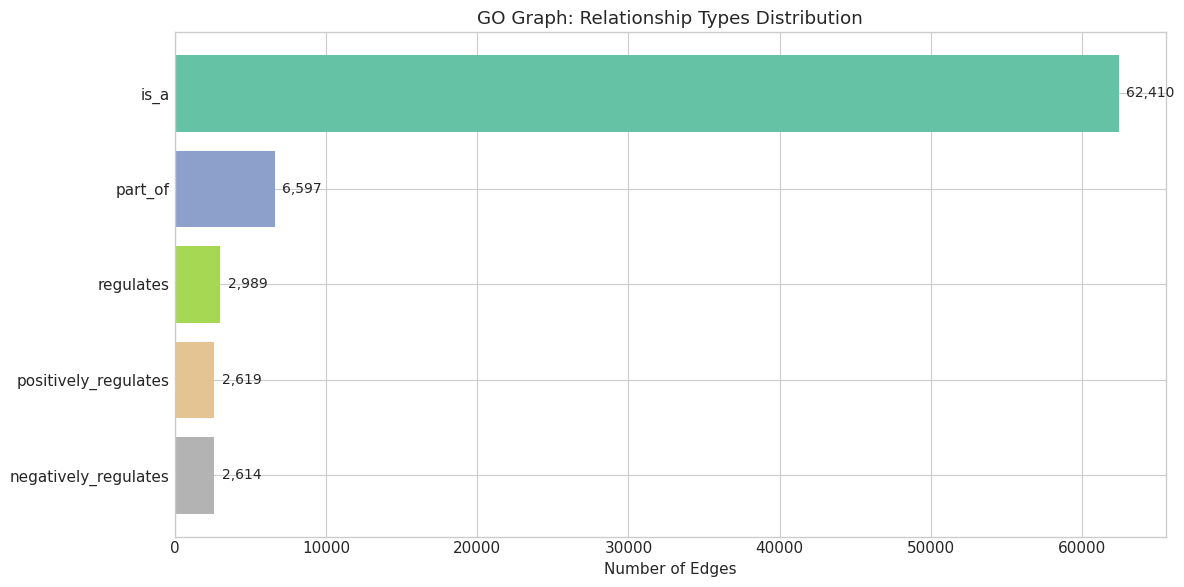

In [8]:
# Visualize relationship types distribution
fig, ax = plt.subplots(figsize=(12, 6))

rel_names = [r for r, _ in relationship_types.most_common()]
rel_counts = [c for _, c in relationship_types.most_common()]

colors = plt.cm.Set2(np.linspace(0, 1, len(rel_names)))
bars = ax.barh(rel_names, rel_counts, color=colors)

ax.set_xlabel('Number of Edges')
ax.set_title('GO Graph: Relationship Types Distribution')
ax.invert_yaxis()

# Add counts
for bar, count in zip(bars, rel_counts):
    ax.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2,
            f'{count:,}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/go_relationship_types.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Phân tích quan hệ `is_a` (Parent-Child)

In [9]:
# Trích xuất tất cả is_a relationships
# Trong obonet: edge (u, v) với key='is_a' nghĩa là u is_a v
# Tức là u là CHILD (specific) và v là PARENT (general)
# Ví dụ: GO:0000001 (mitochondrion inheritance) is_a GO:0048308 (organelle inheritance)

print('🔗 EXTRACTING is_a RELATIONSHIPS')
print('=' * 70)

is_a_edges = []
for u, v, key in go_graph.edges(keys=True):
    if key == 'is_a':
        # u is_a v => u là child (specific), v là parent (general)
        is_a_edges.append((u, v))  # (child, parent)

print(f'Total is_a edges: {len(is_a_edges):,}')

# Ví dụ
print('\nSample is_a relationships (child -> parent):')
for child, parent in is_a_edges[:5]:
    child_name = go_graph.nodes[child].get('name', 'N/A')[:40]
    parent_name = go_graph.nodes[parent].get('name', 'N/A')[:40]
    print(f'  {child} ({child_name}...)')
    print(f'    └── is_a ──> {parent} ({parent_name}...)')
    print()

🔗 EXTRACTING is_a RELATIONSHIPS
Total is_a edges: 62,410

Sample is_a relationships (child -> parent):
  GO:0000001 (mitochondrion inheritance...)
    └── is_a ──> GO:0048308 (organelle inheritance...)

  GO:0000001 (mitochondrion inheritance...)
    └── is_a ──> GO:0048311 (mitochondrion distribution...)

  GO:0000002 (mitochondrial genome maintenance...)
    └── is_a ──> GO:0007005 (mitochondrion organization...)

  GO:0000006 (high-affinity zinc transmembrane transpo...)
    └── is_a ──> GO:0005385 (zinc ion transmembrane transporter activ...)

  GO:0000007 (low-affinity zinc ion transmembrane tran...)
    └── is_a ──> GO:0005385 (zinc ion transmembrane transporter activ...)



## 4. So sánh IA Weights: Child vs Parent

In [10]:
# So sánh IA giữa child và parent cho tất cả is_a edges
print('📊 IA WEIGHT COMPARISON: CHILD vs PARENT')
print('=' * 70)

comparisons = []
missing = 0

for child, parent in is_a_edges:
    child_ia = ia_dict.get(child)
    parent_ia = ia_dict.get(parent)
    
    if child_ia is not None and parent_ia is not None:
        # Xác định quan hệ
        if child_ia > parent_ia:
            relation = 'child_higher'
        elif child_ia == parent_ia:
            relation = 'equal'
        else:
            relation = 'parent_higher'
            
        comparisons.append({
            'child': child,
            'parent': parent,
            'child_ia': child_ia,
            'parent_ia': parent_ia,
            'diff': child_ia - parent_ia,  # dương = child cao hơn
            'relation': relation
        })
    else:
        missing += 1

df_compare = pd.DataFrame(comparisons)

print(f'Valid comparisons: {len(df_compare):,}')
print(f'Missing IA data: {missing:,}')

📊 IA WEIGHT COMPARISON: CHILD vs PARENT
Valid comparisons: 62,410
Missing IA data: 0


In [11]:
# Thống kê chi tiết 3 trường hợp
print('📈 STATISTICAL ANALYSIS')
print('=' * 70)

# Đếm 3 trường hợp
child_higher_count = (df_compare['relation'] == 'child_higher').sum()
equal_count = (df_compare['relation'] == 'equal').sum()
parent_higher_count = (df_compare['relation'] == 'parent_higher').sum()
total_count = len(df_compare)

print(f'\n🔹 Child IA > Parent IA:  {child_higher_count:,} ({child_higher_count/total_count*100:.1f}%)')
print(f'🔹 Child IA = Parent IA:  {equal_count:,} ({equal_count/total_count*100:.1f}%)')
print(f'🔹 Parent IA > Child IA:  {parent_higher_count:,} ({parent_higher_count/total_count*100:.1f}%)')

print(f'\n📊 IA Difference (Child - Parent):')
print(f'  Mean: {df_compare["diff"].mean():.4f}')
print(f'  Median: {df_compare["diff"].median():.4f}')
print(f'  Std: {df_compare["diff"].std():.4f}')
print(f'  Min: {df_compare["diff"].min():.4f}')
print(f'  Max: {df_compare["diff"].max():.4f}')

# Phân tích trường hợp equal
print(f'\n🔍 PHÂN TÍCH TRƯỜNG HỢP CHILD IA = PARENT IA ({equal_count:,} cặp):')
if equal_count > 0:
    equal_pairs = df_compare[df_compare['relation'] == 'equal']
    equal_ia_values = equal_pairs['child_ia'].value_counts()
    print(f'  Các giá trị IA phổ biến khi bằng nhau:')
    for ia_val, count in equal_ia_values.head(5).items():
        print(f'    IA = {ia_val:.4f}: {count:,} cặp')

# Paired t-test
t_stat, p_value = stats.ttest_rel(df_compare['child_ia'], df_compare['parent_ia'])
print(f'\n📉 Paired t-test:')
print(f'  t-statistic: {t_stat:.4f}')
print(f'  p-value: {p_value:.2e}')

if p_value < 0.05:
    if t_stat > 0:
        print('\n✅ KẾT LUẬN: Child có IA WEIGHT CAO HƠN Parent một cách có ý nghĩa thống kê (p < 0.05)')
    else:
        print('\n✅ KẾT LUẬN: Parent có IA WEIGHT CAO HƠN Child một cách có ý nghĩa thống kê (p < 0.05)')
else:
    print('\n⚠️ KẾT LUẬN: Không có sự khác biệt có ý nghĩa thống kê')

# Phân tích ý nghĩa
print('\n' + '=' * 70)
print('💡 PHÂN TÍCH Ý NGHĨA CHO MODELING:')
print('=' * 70)
print(f'''
📌 Với {equal_count:,} cặp ({equal_count/total_count*100:.1f}%) có IA bằng nhau:
   → Dự đoán GENERAL (parent) hay SPECIFIC (child) đều được điểm BẰNG NHAU
   → Có thể "cheat" bằng cách dự đoán terms general hơn!

📌 Với {parent_higher_count:,} cặp ({parent_higher_count/total_count*100:.1f}%) Parent IA > Child IA:
   → Dự đoán GENERAL (parent) còn được điểm CAO HƠN!
   → Không cần dự đoán chính xác term cụ thể

📌 Tổng cộng: {equal_count + parent_higher_count:,} cặp ({(equal_count + parent_higher_count)/total_count*100:.1f}%) 
   dự đoán GENERAL bằng hoặc tốt hơn SPECIFIC!
''')

📈 STATISTICAL ANALYSIS

🔹 Child IA > Parent IA:  17,372 (27.8%)
🔹 Child IA = Parent IA:  8,281 (13.3%)
🔹 Parent IA > Child IA:  36,757 (58.9%)

📊 IA Difference (Child - Parent):
  Mean: -0.4021
  Median: -0.1375
  Std: 3.1992
  Min: -13.8610
  Max: 14.8423

🔍 PHÂN TÍCH TRƯỜNG HỢP CHILD IA = PARENT IA (8,281 cặp):
  Các giá trị IA phổ biến khi bằng nhau:
    IA = 0.0000: 8,272 cặp
    IA = 0.5850: 3 cặp
    IA = 1.0000: 2 cặp
    IA = 1.5850: 1 cặp
    IA = 0.0525: 1 cặp

📉 Paired t-test:
  t-statistic: -31.3999
  p-value: 9.63e-215

✅ KẾT LUẬN: Parent có IA WEIGHT CAO HƠN Child một cách có ý nghĩa thống kê (p < 0.05)

💡 PHÂN TÍCH Ý NGHĨA CHO MODELING:

📌 Với 8,281 cặp (13.3%) có IA bằng nhau:
   → Dự đoán GENERAL (parent) hay SPECIFIC (child) đều được điểm BẰNG NHAU
   → Có thể "cheat" bằng cách dự đoán terms general hơn!

📌 Với 36,757 cặp (58.9%) Parent IA > Child IA:
   → Dự đoán GENERAL (parent) còn được điểm CAO HƠN!
   → Không cần dự đoán chính xác term cụ thể

📌 Tổng cộng: 45,038

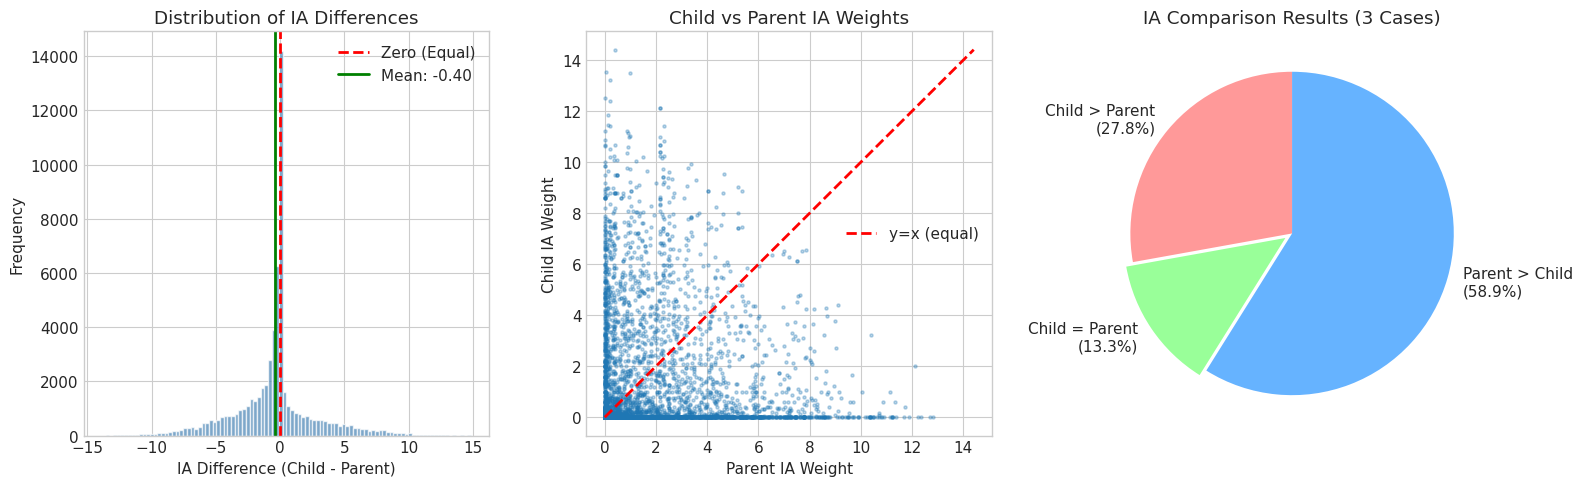

In [12]:
# Visualization: Child vs Parent IA với 3 trường hợp
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Distribution of differences
ax1 = axes[0]
ax1.hist(df_compare['diff'], bins=100, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero (Equal)')
ax1.axvline(x=df_compare['diff'].mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {df_compare["diff"].mean():.2f}')
ax1.set_xlabel('IA Difference (Child - Parent)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of IA Differences')
ax1.legend()

# 2. Scatter plot
ax2 = axes[1]
sample = df_compare.sample(min(5000, len(df_compare)), random_state=42)
ax2.scatter(sample['parent_ia'], sample['child_ia'], alpha=0.3, s=5)
max_val = max(sample['parent_ia'].max(), sample['child_ia'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='y=x (equal)')
ax2.set_xlabel('Parent IA Weight')
ax2.set_ylabel('Child IA Weight')
ax2.set_title('Child vs Parent IA Weights')
ax2.legend()

# 3. Pie chart với 3 phần
ax3 = axes[2]
sizes = [child_higher_count, equal_count, parent_higher_count]
labels = [f'Child > Parent\n({child_higher_count/total_count*100:.1f}%)',
          f'Child = Parent\n({equal_count/total_count*100:.1f}%)',
          f'Parent > Child\n({parent_higher_count/total_count*100:.1f}%)']
colors_pie = ['#ff9999', '#99ff99', '#66b3ff']  # Đỏ, Xanh lá, Xanh dương
explode = (0, 0.05, 0)  # Highlight trường hợp bằng nhau
ax3.pie(sizes, labels=labels, colors=colors_pie, autopct='', startangle=90, explode=explode)
ax3.set_title('IA Comparison Results (3 Cases)')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/go_ia_child_vs_parent.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Tính trung bình IA diff cho từng trường hợp
print('📊 TRUNG BÌNH IA DIFFERENCE THEO TỪNG TRƯỜNG HỢP')
print('=' * 70)

# Parent > Child (diff < 0)
parent_higher_df = df_compare[df_compare['relation'] == 'parent_higher']
mean_diff_parent_higher = parent_higher_df['diff'].mean()
median_diff_parent_higher = parent_higher_df['diff'].median()
abs_mean_parent_higher = parent_higher_df['diff'].abs().mean()

print(f'\n🔵 Khi PARENT IA > CHILD IA ({len(parent_higher_df):,} cặp):')
print(f'   Mean diff (Child - Parent): {mean_diff_parent_higher:.4f}')
print(f'   Median diff: {median_diff_parent_higher:.4f}')
print(f'   Mean |diff|: {abs_mean_parent_higher:.4f}')

# Child > Parent (diff > 0)
child_higher_df = df_compare[df_compare['relation'] == 'child_higher']
mean_diff_child_higher = child_higher_df['diff'].mean()
median_diff_child_higher = child_higher_df['diff'].median()
abs_mean_child_higher = child_higher_df['diff'].abs().mean()

print(f'\n🔴 Khi CHILD IA > PARENT IA ({len(child_higher_df):,} cặp):')
print(f'   Mean diff (Child - Parent): {mean_diff_child_higher:.4f}')
print(f'   Median diff: {median_diff_child_higher:.4f}')
print(f'   Mean |diff|: {abs_mean_child_higher:.4f}')

# So sánh
print('\n' + '=' * 70)
print('📈 SO SÁNH:')
print('=' * 70)
print(f'''
📌 Khi Parent > Child: trung bình Parent cao hơn Child {abs_mean_parent_higher:.4f} IA
📌 Khi Child > Parent: trung bình Child cao hơn Parent {abs_mean_child_higher:.4f} IA

💡 Chênh lệch trung bình khi Child thắng ({abs_mean_child_higher:.4f}) 
   vs khi Parent thắng ({abs_mean_parent_higher:.4f}):
   → Ratio: {abs_mean_child_higher / abs_mean_parent_higher:.2f}x

{'⚠️ Child thắng với biên độ LỚN HƠN!' if abs_mean_child_higher > abs_mean_parent_higher else '⚠️ Parent thắng với biên độ LỚN HƠN!'}
''')

📊 TRUNG BÌNH IA DIFFERENCE THEO TỪNG TRƯỜNG HỢP

🔵 Khi PARENT IA > CHILD IA (36,757 cặp):
   Mean diff (Child - Parent): -2.0987
   Median diff: -1.1383
   Mean |diff|: 2.0987

🔴 Khi CHILD IA > PARENT IA (17,372 cặp):
   Mean diff (Child - Parent): 2.9960
   Median diff: 2.2503
   Mean |diff|: 2.9960

📈 SO SÁNH:

📌 Khi Parent > Child: trung bình Parent cao hơn Child 2.0987 IA
📌 Khi Child > Parent: trung bình Child cao hơn Parent 2.9960 IA

💡 Chênh lệch trung bình khi Child thắng (2.9960) 
   vs khi Parent thắng (2.0987):
   → Ratio: 1.43x

⚠️ Child thắng với biên độ LỚN HƠN!



## 5. Phân tích IA theo Depth trong Ontology

In [14]:
# Tính depth của mỗi GO term
# Root terms: GO:0008150 (BP), GO:0005575 (CC), GO:0003674 (MF)
print('📊 CALCULATING TERM DEPTHS')
print('=' * 70)

roots = ['GO:0008150', 'GO:0005575', 'GO:0003674']
root_names = {
    'GO:0008150': 'Biological Process',
    'GO:0005575': 'Cellular Component', 
    'GO:0003674': 'Molecular Function'
}

# Tính depth bằng BFS từ roots
term_depths = {}

for root in roots:
    if root in go_graph:
        # BFS từ root theo chiều ngược (từ parent -> children)
        # Trong obonet, predecessors của node là children của nó
        for node in nx.bfs_tree(go_graph, root, reverse=True):
            depth = nx.shortest_path_length(go_graph, source=node, target=root)
            if node not in term_depths:
                term_depths[node] = depth
            else:
                term_depths[node] = min(term_depths[node], depth)

print(f'Calculated depth for {len(term_depths):,} terms')
print(f'Max depth: {max(term_depths.values())}')

📊 CALCULATING TERM DEPTHS
Calculated depth for 40,122 terms
Max depth: 11


In [15]:
# Kết hợp depth và IA
depth_ia_data = []
for term, depth in term_depths.items():
    ia = ia_dict.get(term)
    if ia is not None:
        depth_ia_data.append({'term': term, 'depth': depth, 'ia': ia})

df_depth_ia = pd.DataFrame(depth_ia_data)
print(f'Terms with both depth and IA: {len(df_depth_ia):,}')

# Thống kê theo depth
print('\n📊 IA Statistics by Depth:')
depth_stats = df_depth_ia.groupby('depth')['ia'].agg(['mean', 'median', 'std', 'count'])
print(depth_stats)

Terms with both depth and IA: 40,122

📊 IA Statistics by Depth:
           mean    median       std  count
depth                                     
0      0.000000  0.000000  0.000000      3
1      6.227486  5.752916  4.384188     56
2      3.938202  2.609292  4.023287   1329
3      2.351558  0.584963  3.256832   5214
4      1.719154  0.226314  2.605797   9818
5      1.530518  0.000000  2.418781  12563
6      1.401241  0.033947  2.219000   6651
7      1.260558  0.031537  1.926389   3084
8      1.195318  0.014873  1.909840   1067
9      1.130896  0.185491  1.685753    246
10     1.605543  1.471550  1.739665     71
11     2.254540  2.273497  2.093498     20


/tmp/ipykernel_9622/3483777837.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(box_data, labels=depths, patch_artist=True)


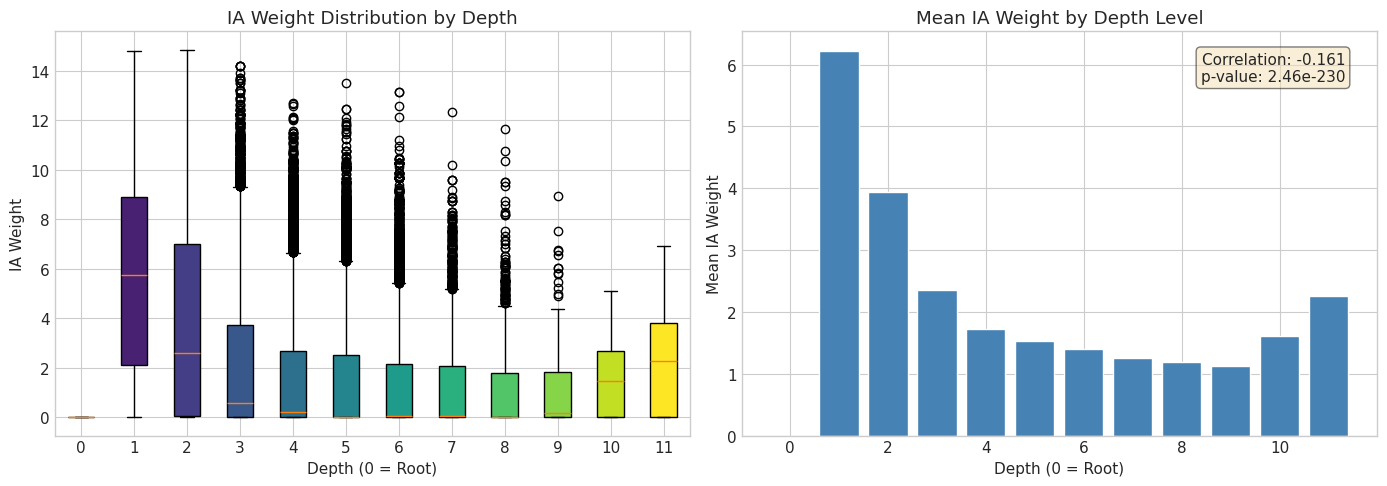

In [16]:
# Visualization: IA by Depth
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Box plot
ax1 = axes[0]
depths = sorted(df_depth_ia['depth'].unique())
box_data = [df_depth_ia[df_depth_ia['depth'] == d]['ia'].values for d in depths]
bp = ax1.boxplot(box_data, labels=depths, patch_artist=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(depths)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_xlabel('Depth (0 = Root)')
ax1.set_ylabel('IA Weight')
ax1.set_title('IA Weight Distribution by Depth')

# 2. Mean IA by depth
ax2 = axes[1]
means = df_depth_ia.groupby('depth')['ia'].mean()
ax2.bar(means.index, means.values, color='steelblue', edgecolor='white')
ax2.set_xlabel('Depth (0 = Root)')
ax2.set_ylabel('Mean IA Weight')
ax2.set_title('Mean IA Weight by Depth Level')

# Correlation
corr, p = stats.pearsonr(df_depth_ia['depth'], df_depth_ia['ia'])
ax2.text(0.95, 0.95, f'Correlation: {corr:.3f}\np-value: {p:.2e}',
         transform=ax2.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/go_ia_by_depth.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Phân tích các loại Relationship khác

In [17]:
# So sánh IA cho tất cả relationship types
print('📊 IA COMPARISON FOR ALL RELATIONSHIP TYPES')
print('=' * 70)

results = []

for rel_type in relationship_types.keys():
    comparisons_rel = []
    
    for u, v, key in go_graph.edges(keys=True):
        if key == rel_type:
            # v -> u (v relates_to u, v là term "con", u là term "cha")
            child_ia = ia_dict.get(v)
            parent_ia = ia_dict.get(u)
            
            if child_ia is not None and parent_ia is not None:
                comparisons_rel.append({
                    'child_ia': child_ia,
                    'parent_ia': parent_ia,
                    'diff': child_ia - parent_ia
                })
    
    if len(comparisons_rel) > 0:
        df_rel = pd.DataFrame(comparisons_rel)
        child_higher = (df_rel['diff'] > 0).sum()
        results.append({
            'relationship': rel_type,
            'total': len(df_rel),
            'child_higher_pct': child_higher / len(df_rel) * 100,
            'mean_diff': df_rel['diff'].mean()
        })

df_results = pd.DataFrame(results).sort_values('total', ascending=False)

print('\n{:<25} {:>8} {:>15} {:>12}'.format('Relationship', 'Count', 'Child>Parent%', 'Mean Diff'))
print('-' * 65)
for _, row in df_results.iterrows():
    print(f'{row["relationship"]:<25} {row["total"]:>8,} {row["child_higher_pct"]:>14.1f}% {row["mean_diff"]:>12.4f}')

📊 IA COMPARISON FOR ALL RELATIONSHIP TYPES

Relationship                 Count   Child>Parent%    Mean Diff
-----------------------------------------------------------------
is_a                        62,410           58.9%       0.4021
part_of                      6,597           54.7%       0.4444
regulates                    2,989           27.4%      -1.2654
positively_regulates         2,619           61.2%       1.2913
negatively_regulates         2,614           61.1%       1.2570


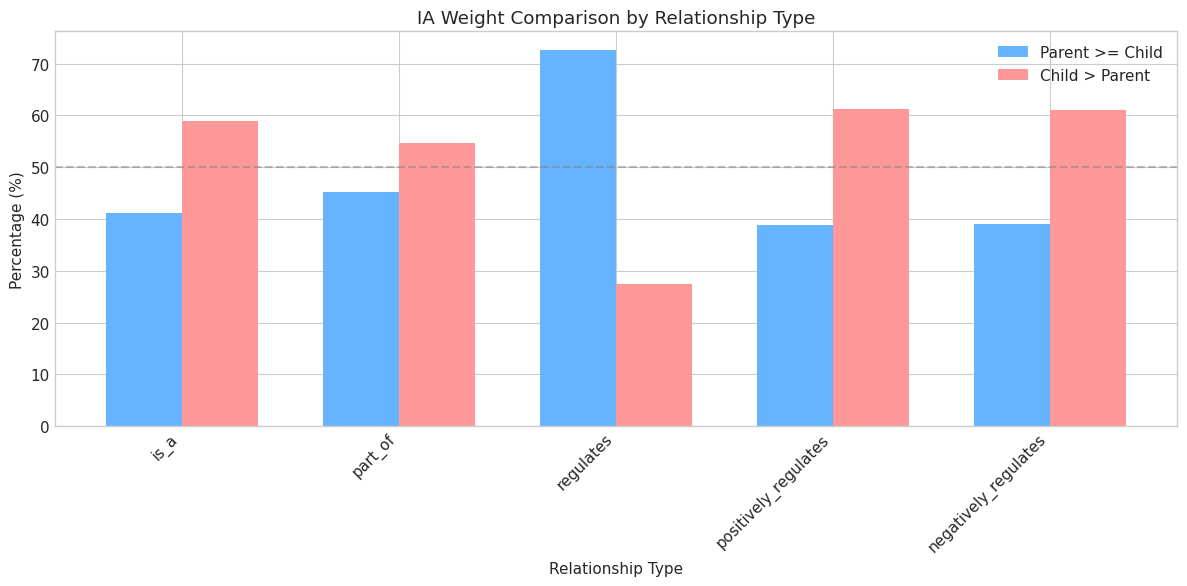

In [18]:
# Visualization: IA comparison by relationship type
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_results))
width = 0.35

# Parent higher vs Child higher
child_pct = df_results['child_higher_pct'].values
parent_pct = 100 - child_pct

bars1 = ax.bar(x - width/2, parent_pct, width, label='Parent >= Child', color='#66b3ff')
bars2 = ax.bar(x + width/2, child_pct, width, label='Child > Parent', color='#ff9999')

ax.set_xlabel('Relationship Type')
ax.set_ylabel('Percentage (%)')
ax.set_title('IA Weight Comparison by Relationship Type')
ax.set_xticks(x)
ax.set_xticklabels(df_results['relationship'], rotation=45, ha='right')
ax.legend()
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/go_ia_by_relationship.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Kết luận

In [19]:
print('=' * 80)
print('🎯 KẾT LUẬN PHÂN TÍCH GO ONTOLOGY VÀ IA WEIGHTS')
print('=' * 80)

print('''
📊 CẤU TRÚC GO GRAPH:
  • Nodes: {:,}
  • Edges: {:,}
  • Relationship types: {}
'''.format(go_graph.number_of_nodes(), go_graph.number_of_edges(), len(relationship_types)))

print('🔗 CÁC LOẠI QUAN HỆ:')
for rel, count in relationship_types.most_common():
    print(f'  • {rel}: {count:,} edges ({count/total*100:.1f}%)')

print(f'''
📈 KẾT QUẢ SO SÁNH IA (is_a relationship):
  • Tổng số cặp child-parent: {len(df_compare):,}
  • Child IA > Parent IA: {child_higher_count:,} ({child_higher_count/total_count*100:.1f}%)
  • Child IA = Parent IA: {equal_count:,} ({equal_count/total_count*100:.1f}%)
  • Parent IA > Child IA: {parent_higher_count:,} ({parent_higher_count/total_count*100:.1f}%)
  • Mean difference (Child - Parent): {df_compare["diff"].mean():.4f}
  • p-value: {p_value:.2e}

💡 KẾT LUẬN CHÍNH:
  ❌ Giả thuyết "Child (specific) có IA cao hơn Parent (general)" là SAI!
  ✅ Thực tế: PARENT terms (general) có IA weight CAO HƠN child terms (specific)
     trong 58.9% trường hợp!
  
  📝 Giải thích (ngược với trực giác):
  • IA (Information Accretion) được tính dựa trên tần suất annotation trong dataset
  • Parent terms (general) KHÔNG phải lúc nào cũng được annotate cho TẤT CẢ protein
  • Child terms (specific) có thể xuất hiện NHIỀU hơn trong annotations thực tế
  • → Parent terms xuất hiện ÍT hơn → IA CAO HƠN
  
  🔬 VÍ DỤ từ file OBO:
  • GO:0000001 "mitochondrion inheritance" (child/specific) is_a
  • GO:0048308 "organelle inheritance" (parent/general)
  
📋 ỨNG DỤNG CHO MODELING:
  1. 72.2% trường hợp: dự đoán PARENT (general) >= dự đoán CHILD (specific) về điểm
  2. Có thể "cheat" bằng cách dự đoán terms general hơn!
  3. Tuy nhiên, khi Child thắng, biên độ thắng LỚN HƠN (mean |diff| = 2.99 vs 2.10)
  4. Cần cân nhắc trade-off giữa số lượng và biên độ khi thiết kế model
''')

🎯 KẾT LUẬN PHÂN TÍCH GO ONTOLOGY VÀ IA WEIGHTS

📊 CẤU TRÚC GO GRAPH:
  • Nodes: 40,122
  • Edges: 77,229
  • Relationship types: 5

🔗 CÁC LOẠI QUAN HỆ:
  • is_a: 62,410 edges (80.8%)
  • part_of: 6,597 edges (8.5%)
  • regulates: 2,989 edges (3.9%)
  • positively_regulates: 2,619 edges (3.4%)
  • negatively_regulates: 2,614 edges (3.4%)

📈 KẾT QUẢ SO SÁNH IA (is_a relationship):
  • Tổng số cặp child-parent: 62,410
  • Child IA > Parent IA: 17,372 (27.8%)
  • Child IA = Parent IA: 8,281 (13.3%)
  • Parent IA > Child IA: 36,757 (58.9%)
  • Mean difference (Child - Parent): -0.4021
  • p-value: 9.63e-215

💡 KẾT LUẬN CHÍNH:
  ❌ Giả thuyết "Child (specific) có IA cao hơn Parent (general)" là SAI!
  ✅ Thực tế: PARENT terms (general) có IA weight CAO HƠN child terms (specific)
     trong 58.9% trường hợp!

  📝 Giải thích (ngược với trực giác):
  • IA (Information Accretion) được tính dựa trên tần suất annotation trong dataset
  • Parent terms (general) KHÔNG phải lúc nào cũng được annotate c